In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import os
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm

# Scikit-learn imports
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Smoothing filters
from scipy.signal import savgol_filter

In [12]:
def rasterize_shape(points, image_size=64):
    """
    Converts a 2D shape into a binary raster image.

    The shape is centered, scaled to fit, and drawn as a white contour on a black background.

    Args:
        points (np.ndarray): An array of shape (N, 2) representing the shape's points.
        image_size (int): The width and height of the output square image.

    Returns:
        np.ndarray: A grayscale raster image of shape (image_size, image_size).
    """
    if points.shape[0] < 2:
        return np.zeros((image_size, image_size), dtype=np.uint8)

    # Center the points
    centroid = np.mean(points, axis=0)
    centered_points = points - centroid

    # Normalize scale
    max_dist = np.max(np.linalg.norm(centered_points, axis=1))
    if max_dist < 1e-6:
        return np.zeros((image_size, image_size), dtype=np.uint8)

    normalized_points = centered_points / max_dist

    # Map to image coordinates with a small margin
    image_points = (normalized_points + 1) / 2 * (image_size * 0.9) + (image_size * 0.05)
    image_points = image_points.astype(np.int32)

    # Draw the shape
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    cv2.polylines(image, [image_points], isClosed=False, color=255, thickness=1)

    return image


def extract_pca_features(X, n_components=30, image_size=64, pca_model=None):
    """
    Extracts features from shapes using the full pipeline.

    Args:
        X (list of np.ndarray): A list of shapes, where each shape is an (N_i, 2) array.
        n_components (int): The number of principal components to keep.
        image_size (int): The size of the rasterized image.
        pca_model (PCA, optional): A pre-trained PCA model. If None, a new model is trained.

    Returns:
        tuple: A tuple containing:
            - np.ndarray: The extracted feature array of shape (len(X), n_components).
            - PCA: The trained or provided PCA model.
    """
    processed_points_list = []
    for points in X:
        # 1. 1D Smoothing (Savitzky-Golay)
        smoothed_points = points
        if len(points) > 5:
            window_length = min(len(points) - 1, int(len(points) * 0.1) * 2 + 1)
            if window_length >= 5:
                x_smooth = savgol_filter(points[:, 0], window_length, 3)
                y_smooth = savgol_filter(points[:, 1], window_length, 3)
                smoothed_points = np.stack([x_smooth, y_smooth], axis=1)

        # 2. PCA-based Alignment
        aligned_points = smoothed_points
        if len(smoothed_points) > 2:
            points_mean = np.mean(smoothed_points, axis=0)
            centered = smoothed_points - points_mean
            pca_align = PCA(n_components=2)
            aligned_points = pca_align.fit_transform(centered)

        processed_points_list.append(aligned_points)

    # 3. Rasterization
    rasterized_images = np.array([rasterize_shape(p, image_size) for p in processed_points_list])

    # 4. 2D Gaussian Blur
    blurred_images = np.array([cv2.GaussianBlur(img, (3, 3), 0) for img in rasterized_images])

    # 5. Final PCA for Feature Extraction
    flattened_images = blurred_images.reshape(len(X), -1)
    
    is_training = (pca_model is None)
    if is_training:
        pca_model = PCA(n_components=n_components, whiten=True, random_state=42)
        features = pca_model.fit_transform(flattened_images)
    else:
        features = pca_model.transform(flattened_images)

    return features, pca_model

In [13]:
def load_dataset_from_json(filepath="data/dataset.json"):
    """
    Loads the shapes and labels from a JSON file.

    Args:
        filepath (str): The path to the JSON dataset file.

    Returns:
        tuple: A tuple containing:
            - list: A list of numpy arrays, where each array represents a shape.
            - np.ndarray: An array of labels.
            - dict: A dictionary containing the class map.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Dataset not found at '{filepath}'. Please run `generate_dataset.py` first.")

    with open(filepath, 'r') as f:
        data = json.load(f)
    
    # Convert lists back to numpy arrays
    shapes = [np.array(s) for s in data['shapes']]
    labels = np.array(data['labels'])
    class_map = data['metadata']['class_map']
    
    print(f"Loaded {len(shapes)} shapes from '{filepath}'.")
    return shapes, labels, class_map

# Load the dataset
X, y, CLASS_MAP = load_dataset_from_json()
CLASS_LABELS = list(CLASS_MAP.values())

# Split into training and testing sets
X_train_points, X_test_points, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train_points)} samples")
print(f"Test set size: {len(X_test_points)} samples")

Loaded 6000 shapes from 'data/dataset.json'.
Training set size: 4200 samples
Test set size: 1800 samples


In [14]:
# --- Global Hyperparameters ---
# These values were determined through GridSearchCV in a separate analysis.
# Feature Engineering
OPTIMAL_N_COMPONENTS = 25
IMAGE_SIZE = 32

# Random Forest
RF_MAX_DEPTH = 14
RF_MIN_SAMPLES_LEAF = 1
RF_N_ESTIMATORS = 175

# SVM
SVM_C = 8
SVM_GAMMA = 'scale'
SVM_KERNEL = 'rbf'

--- Analyzing PCA for optimal n_components ---


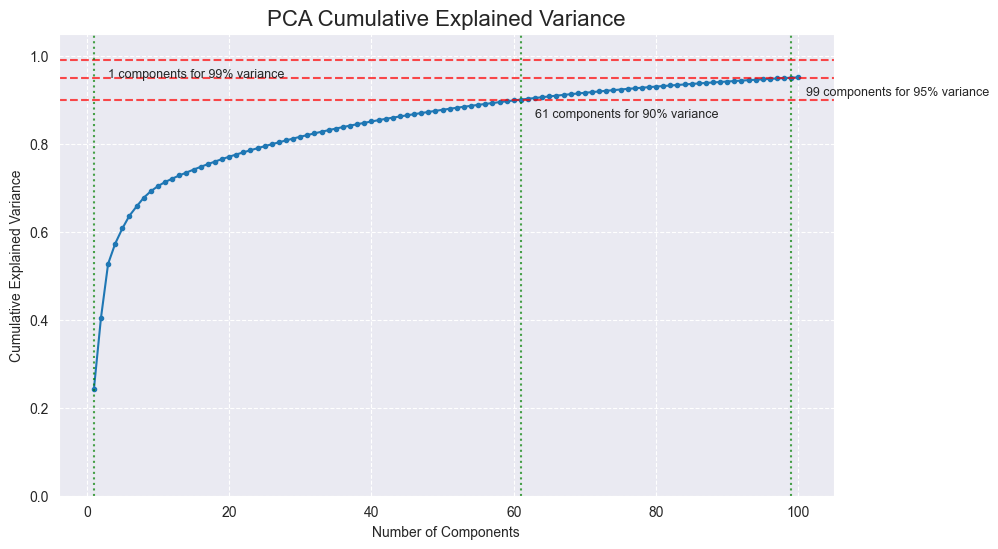

In [15]:
def plot_pca_variance_analysis(X_train):
    """
    Performs PCA and plots the cumulative explained variance.
    """
    print("--- Analyzing PCA for optimal n_components ---")
    
    # We only need the PCA model, so we don't care about the features here
    _, temp_pca_model = extract_pca_features(X_train, n_components=min(len(X_train), 100), image_size=IMAGE_SIZE)
    
    cumulative_variance = np.cumsum(temp_pca_model.explained_variance_ratio_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='.', linestyle='-')
    
    # Highlight key thresholds
    for threshold in [0.90, 0.95, 0.99]:
        n_comp = np.argmax(cumulative_variance >= threshold) + 1
        plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.7)
        plt.axvline(x=n_comp, color='g', linestyle=':', alpha=0.7)
        plt.text(n_comp + 2, threshold - 0.04, f'{n_comp} components for {threshold*100:.0f}% variance', fontsize=9)
    
    plt.title('PCA Cumulative Explained Variance', fontsize=16)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True, which='both', linestyle='--')
    plt.ylim(0, 1.05)
    plt.show()

# Run the analysis on a subset for speed
plot_pca_variance_analysis(X_train_points[:1000])

In [16]:
print("Extracting features from the training set...")
X_train_pca, pca_model = extract_pca_features(
    X_train_points,
    n_components=OPTIMAL_N_COMPONENTS,
    image_size=IMAGE_SIZE,
    pca_model=None  # Train a new model
)

print("\nTraining classifiers...")
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=RF_N_ESTIMATORS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF,
        random_state=42
    ),
    "SVM": SVC(
        C=SVM_C,
        gamma=SVM_GAMMA,
        kernel=SVM_KERNEL,
        random_state=42
    ),
}

trained_models = {}
for name, model in models.items():
    print(f"- Training {name}...")
    model.fit(X_train_pca, y_train)
    trained_models[name] = model
    train_accuracy = model.score(X_train_pca, y_train)
    print(f"  Training Accuracy: {train_accuracy:.4f}")

print("\nModels trained successfully.")

Extracting features from the training set...

Training classifiers...
- Training Random Forest...
  Training Accuracy: 1.0000
- Training SVM...
  Training Accuracy: 1.0000

Models trained successfully.


In [17]:
# from the generation script. This is for demonstration purposes.
from generate_dataset import generate_shape_data 

def run_robustness_tests(trained_models, pca_model, test_params):
    """
    Runs a suite of robustness tests and returns the results.
    """
    results = {}
    
    # Test against varying noise levels
    noise_results = []
    for noise_level in tqdm(test_params['noise_levels'], desc="Testing vs. Noise"):
        X_test_pts, y_test_pts = generate_shape_data(n_shapes_per_class=250, n_points_per_shape=200, noise_bound=noise_level, random_state=42+i)
        X_test_pca, _ = extract_pca_features(X_test_pts, pca_model=pca_model, image_size=IMAGE_SIZE)
        res = {'param_value': noise_level}
        for name, clf in trained_models.items():
            res[f'accuracy_{name}'] = clf.score(X_test_pca, y_test_pts)
        noise_results.append(res)
    results['noise'] = pd.DataFrame(noise_results)
    
    # Test against varying number of shapes
    shape_count_results = []
    for n_shapes in tqdm(test_params['shape_counts'], desc="Testing vs. # Shapes"):
        # In a real test, we would train on n_shapes and test on a fixed set.
        # Here, we test on a dataset of that size to check consistency.
        X_test_pts, y_test_pts = generate_shape_data(n_shapes_per_class=n_shapes, n_points_per_shape=200, noise_bound=0.5, random_state=42+i)
        X_test_pca, _ = extract_pca_features(X_test_pts, pca_model=pca_model, image_size=IMAGE_SIZE)
        res = {'param_value': n_shapes}
        for name, clf in trained_models.items():
            res[f'accuracy_{name}'] = clf.score(X_test_pca, y_test_pts)
        shape_count_results.append(res)
    results['shape_count'] = pd.DataFrame(shape_count_results)
    
    # Test against varying number of points
    point_count_results = []
    for n_points in tqdm(test_params['point_counts'], desc="Testing vs. # Points"):
        X_test_pts, y_test_pts = generate_shape_data(n_shapes_per_class=250, n_points_per_shape=n_points, noise_bound=0.5, random_state=42+i)
        X_test_pca, _ = extract_pca_features(X_test_pts, pca_model=pca_model, image_size=IMAGE_SIZE)
        res = {'param_value': n_points}
        for name, clf in trained_models.items():
            res[f'accuracy_{name}'] = clf.score(X_test_pca, y_test_pts)
        point_count_results.append(res)
    results['point_count'] = pd.DataFrame(point_count_results)
    
    return results


test_parameters = {
    'noise_levels': [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25],
    'shape_counts': [100, 200, 300, 500, 750, 1000],
    'point_counts': [50, 75, 100, 150, 200, 300]
}

robustness_results = run_robustness_tests(trained_models, pca_model, test_parameters)

Testing vs. Noise:   0%|          | 0/7 [00:00<?, ?it/s]

Testing vs. # Shapes:   0%|          | 0/6 [00:00<?, ?it/s]

Testing vs. # Points:   0%|          | 0/6 [00:00<?, ?it/s]

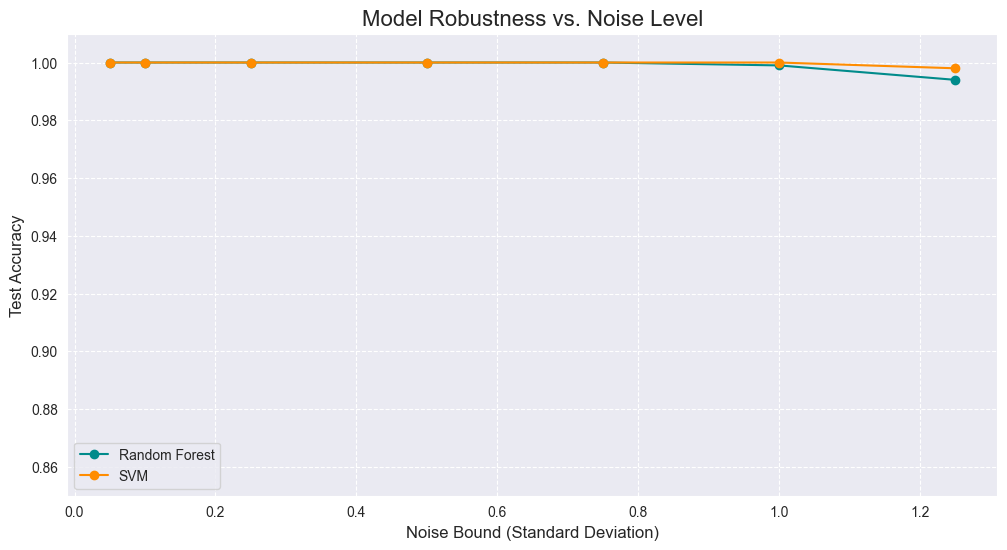

--- Results Summary ---


,param_value,accuracy_Random Forest,accuracy_SVM
0,0.05,1.000,1.000
1,0.10,1.000,1.000
2,0.25,1.000,1.000
3,0.50,1.000,1.000
4,0.75,1.000,1.000
5,1.00,0.999,1.000
6,1.25,0.994,0.998


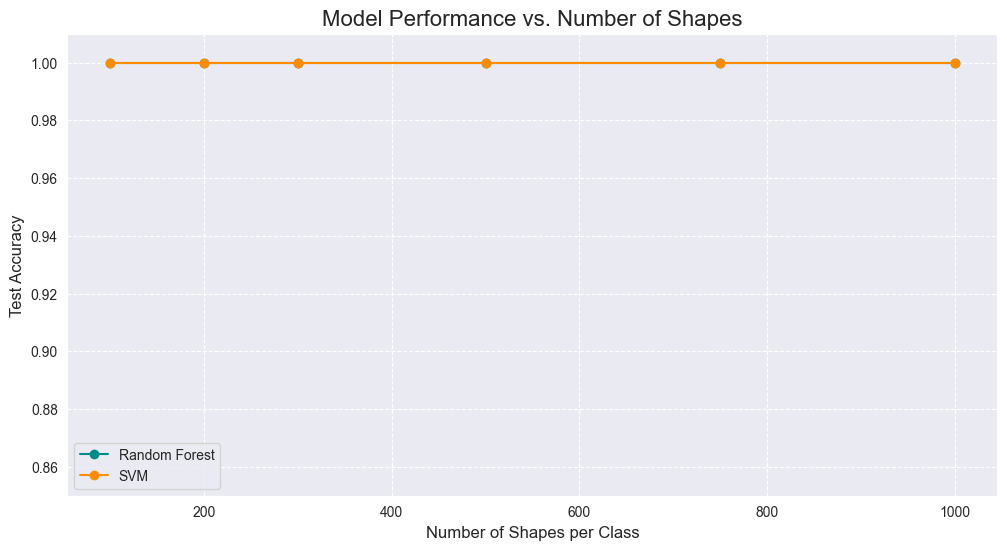

--- Results Summary ---


,param_value,accuracy_Random Forest,accuracy_SVM
0,100,1.0,1.0
1,200,1.0,1.0
2,300,1.0,1.0
3,500,1.0,1.0
4,750,1.0,1.0
5,1000,1.0,1.0


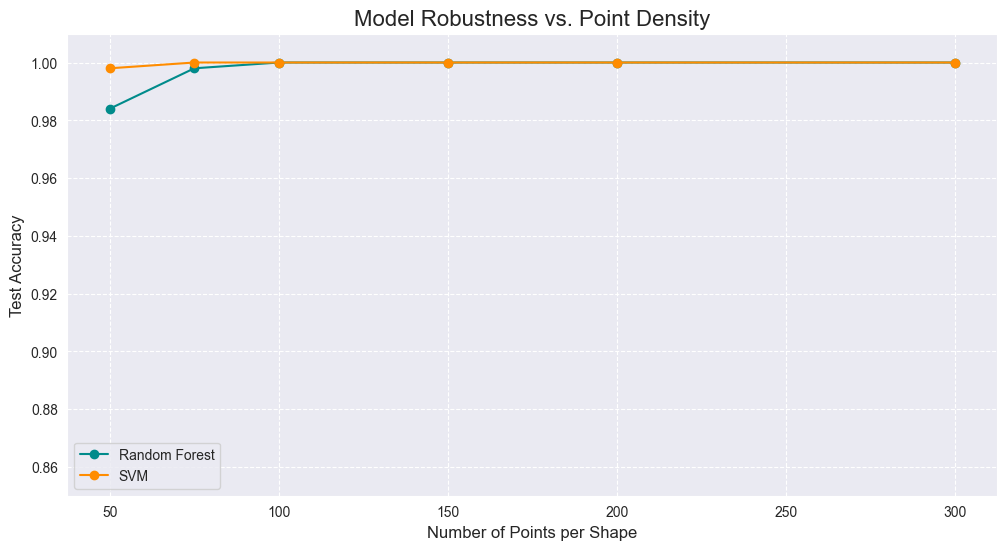

--- Results Summary ---


,param_value,accuracy_Random Forest,accuracy_SVM
0,50,0.984,0.998
1,75,0.998,1.000
2,100,1.000,1.000
3,150,1.000,1.000
4,200,1.000,1.000
5,300,1.000,1.000


In [18]:
def plot_robustness_results(results_df, param_name, title, xlabel):
    """
    Plots the results of a single robustness test.
    """
    plt.figure(figsize=(12, 6))
    
    model_colors = {"Random Forest": 'darkcyan', "SVM": 'darkorange'}
    for model_name in model_colors.keys():
        plt.plot(results_df['param_value'], results_df[f'accuracy_{model_name}'], marker='o', linestyle='-', label=model_name, color=model_colors[model_name])
        
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.ylim(0.85, 1.01)
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.show()
    
    # Print table
    print("--- Results Summary ---")
    display(results_df)

# Plot Noise Robustness
plot_robustness_results(
    robustness_results['noise'], 
    'noise',
    'Model Robustness vs. Noise Level',
    'Noise Bound (Standard Deviation)'
)

# Plot Shape Count Robustness
plot_robustness_results(
    robustness_results['shape_count'], 
    'shape_count',
    'Model Performance vs. Number of Shapes',
    'Number of Shapes per Class'
)

# Plot Point Count Robustness
plot_robustness_results(
    robustness_results['point_count'], 
    'point_count',
    'Model Robustness vs. Point Density',
    'Number of Points per Shape'
)

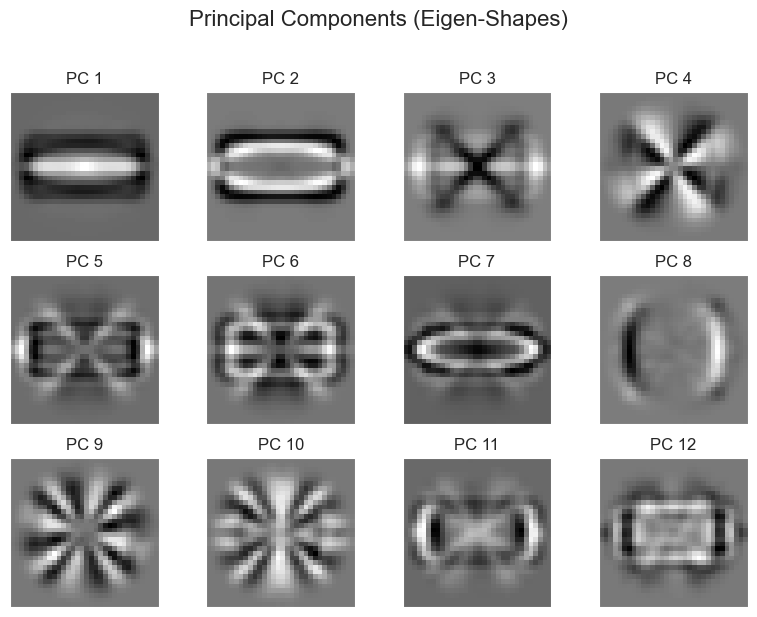

In [19]:
def plot_pca_components(pca, n_components_to_plot=12, image_size=32):
    """
    Visualizes the first N principal components (eigen-shapes) from a PCA model.
    """
    n_cols = 4
    n_rows = int(np.ceil(n_components_to_plot / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))
    fig.suptitle('Principal Components (Eigen-Shapes)', fontsize=16, y=1.02)
    
    for i, ax in enumerate(axes.flat):
        if i < pca.n_components_:
            component = pca.components_[i].reshape(image_size, image_size)
            ax.imshow(component, cmap='gray')
            ax.set_title(f'PC {i+1}')
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()

if pca_model:
    plot_pca_components(pca_model, n_components_to_plot=12, image_size=IMAGE_SIZE)
else:
    print("PCA model not available for plotting.")

Extracting features from the test set...
Final Test Accuracy for Random Forest: 0.9983
Final Test Accuracy for SVM: 0.9994


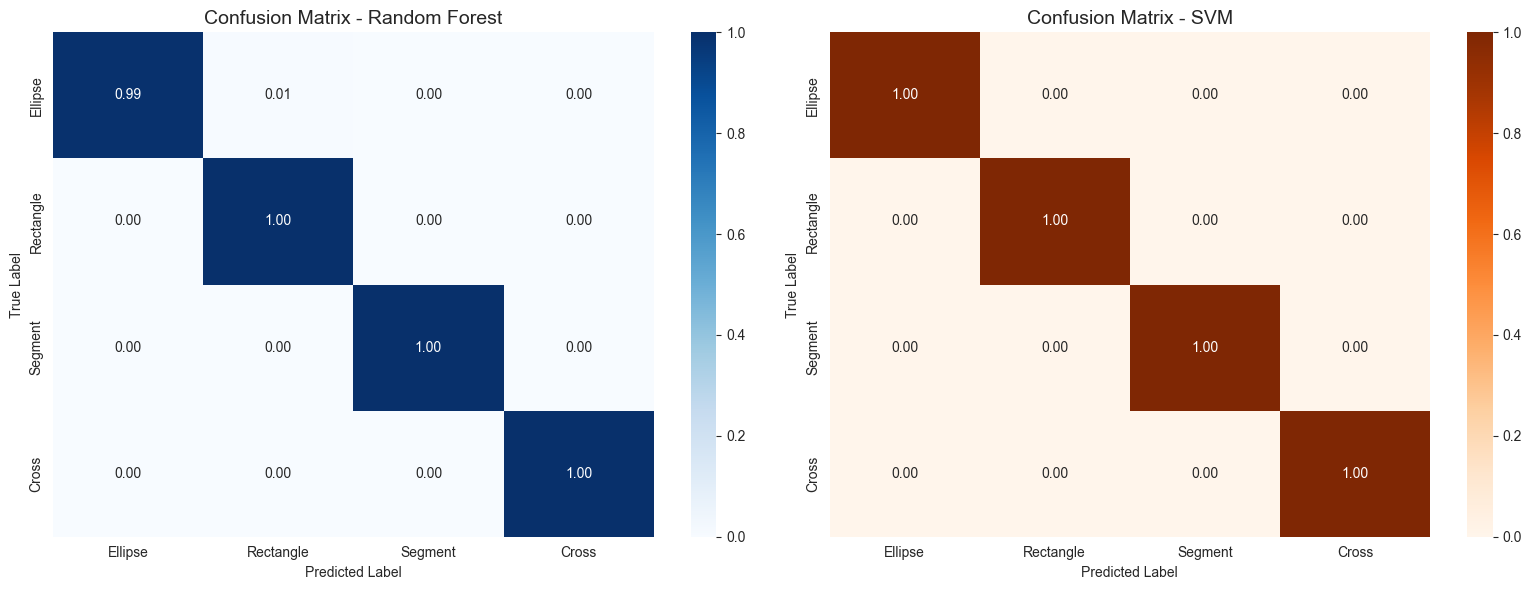

In [20]:
print("Extracting features from the test set...")
X_test_pca, _ = extract_pca_features(
    X_test_points, 
    pca_model=pca_model, # Use the already trained model
    image_size=IMAGE_SIZE
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
model_cmaps = {"Random Forest": 'Blues', "SVM": 'Oranges'}

for i, (name, model) in enumerate(trained_models.items()):
    y_pred = model.predict(X_test_pca)
    accuracy = model.score(X_test_pca, y_test)
    print(f"Final Test Accuracy for {name}: {accuracy:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    ax = axes[i]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap=model_cmaps[name], ax=ax, 
                xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS, vmin=0, vmax=1)
    ax.set_title(f'Confusion Matrix - {name}', fontsize=14)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()